# fetch

In [ ]:
import ccxt
import pandas as pd
import os
import time

exchange = ccxt.hyperliquid()

markets = exchange.fetch_markets()

spot_pairs = [market['symbol'] for market in markets if market['type'] == 'spot']
spot_count = len(spot_pairs)

print(f"Hyperliquid spot pair num: {spot_count}")

folder_name = 'hyperliquid_spot'
os.makedirs(folder_name, exist_ok=True)


timeframe = '1d'
since = exchange.parse8601('2023-01-01T00:00:00Z')


for symbol in spot_pairs:
    all_ohlcv = []

   
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since)
   
    if ohlcv:
        all_ohlcv.extend(ohlcv)

        ohlcv_df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'], unit='ms')

        file_name = os.path.join(folder_name, f"{symbol.replace('/', '_')}_ohlcv.csv")
        ohlcv_df.to_csv(file_name, index=False)

        print(f"Saved OHLCV data for {symbol} to {file_name}")
    else:
        print(f"No data available for {symbol}")

    print("Waiting for 5 seconds...")
    time.sleep(5)

In [41]:
import requests
import pandas as pd

# CoinGecko API URL
url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc"

# 请求参数
params = {
    'vs_currency': 'usd',  # 目标货币
    'days': '365',           # 时间范围
}

# 发起请求
response = requests.get(url, params=params)

# 检查响应状态
if response.status_code == 200:
    # 获取数据
    data = response.json()
    
    # 转换为 DataFrame
    ohlc_df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close'])
    
    # 将时间戳转换为可读格式
    ohlc_df['timestamp'] = pd.to_datetime(ohlc_df['timestamp'], unit='ms')
    
    # 保存到 CSV 文件
    ohlc_df.to_csv('btc_price.csv', index=False)
    print("数据已成功保存到 btc_price.csv")
else:
    print(f"Error: {response.status_code}")

数据已成功保存到 btc_price.csv


In [6]:
import pandas as pd
import os
import numpy as np

# 读取 OHLCV 数据
folder_name = 'hyperliquid_spot'
files = os.listdir(folder_name)

# 创建一个 DataFrame 存储结果
results = []

for file in files:
    if file.endswith('_ohlcv.csv'):
        # 读取 CSV 文件
        file_path = os.path.join(folder_name, file)
        ohlcv_df = pd.read_csv(file_path)

        # 计算 Token symbol
        token_symbol = file.split('_')[0]

        # 将 timestamp 转换为 datetime
        ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'])
        listed_date = ohlcv_df['timestamp'].iloc[0]

        # 计算价格变化
        price_change = {}
        for days in [1, 30, 60]:
            filtered_close = ohlcv_df.loc[ohlcv_df['timestamp'] > listed_date + pd.Timedelta(days=days), 'close']
            if not filtered_close.empty:
                price_change[f'{days}d'] = filtered_close.iloc[0] / ohlcv_df['close'].iloc[0] - 1
            else:
                price_change[f'{days}d'] = np.nan  # 返回 NaN

        # 计算 ATH 和日期
        ath_price = ohlcv_df['close'].max()
        ath_date = ohlcv_df.loc[ohlcv_df['close'].idxmax(), 'timestamp']
        days_to_ath = (ath_date - listed_date).days

        # 计算交易量变化
        vol_change = {}
        for days in [1, 30, 60]:
            filtered_volume = ohlcv_df.loc[ohlcv_df['timestamp'] > listed_date + pd.Timedelta(days=days), 'volume']
            if not filtered_volume.empty:
                vol_change[f'{days}d'] = filtered_volume.iloc[0] / ohlcv_df['volume'].iloc[0] - 1
            else:
                vol_change[f'{days}d'] = np.nan  # 返回 NaN

        # 收集结果
        results.append({
            'Token symbol': token_symbol,
            'Listed date': listed_date,
            'ATH date': ath_date,
            'Price % change 1d': price_change['1d'] * 100 if price_change['1d'] is not np.nan else np.nan,
            'Price % change 30d': price_change['30d'] * 100 if price_change['30d'] is not np.nan else np.nan,
            'Price % change 60d': price_change['60d'] * 100 if price_change['60d'] is not np.nan else np.nan,
            'ATH %': (ath_price / ohlcv_df['close'].iloc[0] - 1) * 100,
            'Day to ATH': days_to_ath,
            'Vol % change 1d': vol_change['1d'] * 100 if vol_change['1d'] is not np.nan else np.nan,
            'Vol % change 30d': vol_change['30d'] * 100 if vol_change['30d'] is not np.nan else np.nan,
            'Vol % change 60d': vol_change['60d'] * 100 if vol_change['60d'] is not np.nan else np.nan,
        })

# 创建最终的 DataFrame
results_df = pd.DataFrame(results)

# 保存结果到 CSV
results_df.to_csv('hyperliquid_spot_summary.csv', index=False)

print("汇总数据已保存到 hyperliquid_spot_summary.csv")

汇总数据已保存到 hyperliquid_spot_summary.csv


In [11]:
import pandas as pd
import os
import numpy as np

# 读取 OHLCV 数据
folder_name = 'hyperliquid_spot'
files = os.listdir(folder_name)

# 创建一个 DataFrame 存储结果
results = []

for file in files:
    if file.endswith('_ohlcv.csv'):
        # 读取 CSV 文件
        file_path = os.path.join(folder_name, file)
        ohlcv_df = pd.read_csv(file_path)

        # 计算 Token symbol
        token_symbol = file.split('_')[0]

        # 将 timestamp 转换为 datetime
        ohlcv_df['timestamp'] = pd.to_datetime(ohlcv_df['timestamp'])
        listed_date = ohlcv_df['timestamp'].iloc[0]

        # 获取上市首日的价格和交易量
        first_day_price = ohlcv_df['close'].iloc[0]
        first_day_volume = ohlcv_df['volume'].iloc[0]

        # 初始化价格和交易量变化的字典
        price_change = {}
        vol_change = {}

        for days in [1, 30, 60]:
            # 计算价格变化
            filtered_close = ohlcv_df.loc[ohlcv_df['timestamp'] >= listed_date + pd.Timedelta(days=days), 'close']
            if not filtered_close.empty:
                price_change[f'Price after {days}d'] = filtered_close.iloc[0]
                price_change[f'Price % change {days}d'] = filtered_close.iloc[0] / first_day_price - 1
            else:
                price_change[f'Price after {days}d'] = np.nan
                price_change[f'Price % change {days}d'] = np.nan

            # 计算交易量变化
            filtered_volume = ohlcv_df.loc[ohlcv_df['timestamp'] >= listed_date + pd.Timedelta(days=days), 'volume']
            if not filtered_volume.empty:
                vol_change[f'Volume after {days}d'] = filtered_volume.iloc[0]
                vol_change[f'Vol % change {days}d'] = filtered_volume.iloc[0] / first_day_volume - 1
            else:
                vol_change[f'Volume after {days}d'] = np.nan
                vol_change[f'Vol % change {days}d'] = np.nan

        # 计算 ATH 和日期
        ath_price = ohlcv_df['close'].max()
        ath_date = ohlcv_df.loc[ohlcv_df['close'].idxmax(), 'timestamp']
        days_to_ath = (ath_date - listed_date).days

        # 收集结果
        results.append({
            'Token symbol': token_symbol,
            'Listed date': listed_date,
            '1st day price': first_day_price,
            '1st day volume': first_day_volume,
            'ATH date': ath_date,
            'ATH %': (ath_price / first_day_price - 1) * 100,
            'Day to ATH': days_to_ath,
            **price_change,
            **vol_change,
        })

# 创建最终的 DataFrame
results_df = pd.DataFrame(results)

# 保存结果到 CSV
results_df.to_csv('hyperliquid_spot_working_table.csv', index=False)

print("汇总数据已保存到 hyperliquid_spot_working_table.csv")


汇总数据已保存到 hyperliquid_spot_working_table.csv


In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件
file_path = 'hyperliquid_spot_working_table.csv'
df = pd.read_csv(file_path)

# 确保 Listed date 列是日期格式
df['Listed date'] = pd.to_datetime(df['Listed date'])

# 添加一列表示上市月份
df['Listed Month'] = df['Listed date'].dt.to_period('M')

# 计算每个分组的平均价格变化百分比（乘以 100）
price_changes = df[['Listed Month', 'Price % change 1d', 'Price % change 30d']].groupby('Listed Month').mean() * 100

# 读取比特币的 OHLC 数据
btc_file_path = 'btc_price.csv'
btc_df = pd.read_csv(btc_file_path)

# 确保时间戳列是日期格式
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])

# 添加一列表示上市月份
btc_df['Listed Month'] = btc_df['timestamp'].dt.to_period('M')

# 计算每个月的平均价格（使用收盘价）
avg_btc_price = btc_df.groupby('Listed Month')['close'].mean()

# 筛选比特币数据，只保留 2024 年 4 月到 12 月的数据
avg_btc_price = avg_btc_price.loc['2024-04':'2024-12']

# 打印价格变化和比特币平均价格
print("Price Changes:")
print(price_changes)
print("\nAverage BTC Price:")
print(avg_btc_price)

# 绘制图形
plt.figure(figsize=(12, 6))

# 绘制条形图
price_changes.plot(kind='bar', ax=plt.gca(), position=1, width=0.4)

# 添加比特币的平均价格线
ax2 = plt.gca().twinx()  # 创建新的 y 轴
avg_btc_price.plot(ax=ax2, color='orange', marker='o', linewidth=2, label='Average BTC Price')

# 添加标记，带有 % 符号
for idx in range(len(price_changes)):
    for col in price_changes.columns:
        plt.text(idx, price_changes[col].iloc[idx], f"{price_changes[col].iloc[idx]:.2f}%", ha='center', va='bottom')

# 设置标题和标签
plt.title('Average Price Change Percentage by Listed Month (1d and 30d) and Average BTC Price')
plt.xlabel('Listed Month')
plt.ylabel('Average Price Change Percentage (%)')
ax2.set_ylabel('Average BTC Price (USD)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# 添加图例
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# 显示图形
plt.show()

Price Changes:
              Price % change 1d  Price % change 30d
Listed Month                                       
2024-04              -11.244815           70.958294
2024-05                7.950628           89.889399
2024-06               -6.771610           56.624464
2024-07                3.144908          -63.199705
2024-08              -16.298072          -63.494697
2024-09               -9.031149           26.055419
2024-10               13.546304          846.056341
2024-11               34.896327          523.691536
2024-12              -23.844927                 NaN

Average BTC Price:
Listed Month
2024-04    66404.000000
2024-05    65105.000000
2024-06    66051.125000
2024-07    62719.285714
2024-08    60626.125000
2024-09    60462.000000
2024-10    65054.428571
2024-11    85171.750000
2024-12    98456.000000
Freq: M, Name: close, dtype: float64


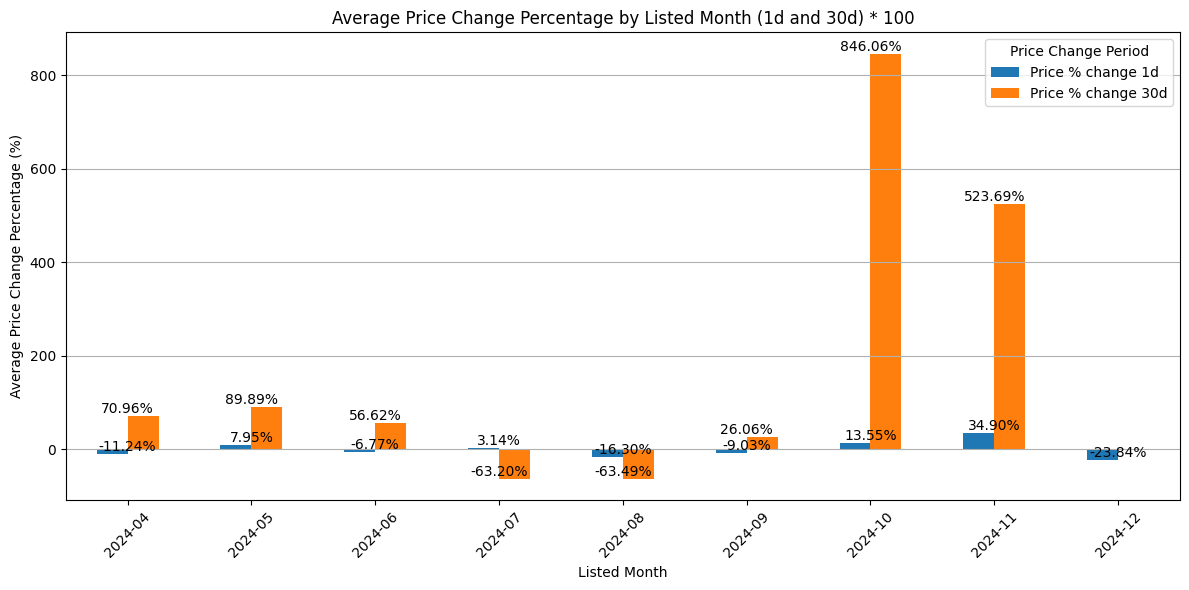

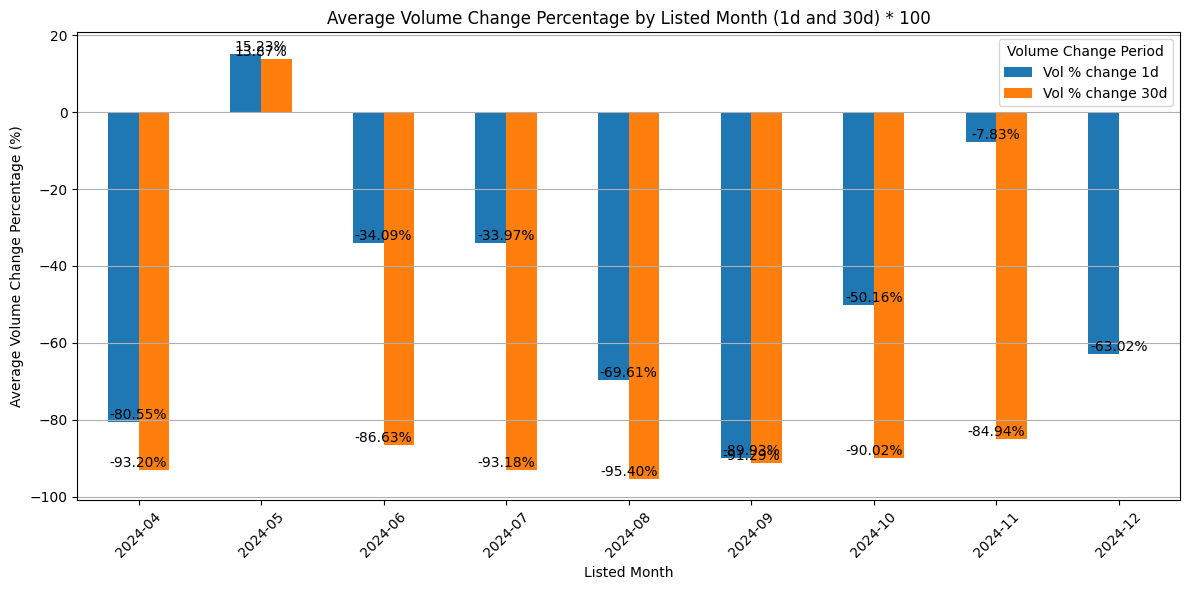

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件
file_path = 'hyperliquid_spot_working_table.csv'
df = pd.read_csv(file_path)

# 确保 Listed date 列是日期格式
df['Listed date'] = pd.to_datetime(df['Listed date'])

# 添加一列表示上市月份
df['Listed Month'] = df['Listed date'].dt.to_period('M')

# 计算每个分组的平均价格变化百分比（乘以 100）
price_changes = df[['Listed Month', 'Price % change 1d', 'Price % change 30d']].groupby('Listed Month').mean() * 100

# 计算每个分组的平均交易量变化百分比（乘以 100）
volume_changes = df[['Listed Month', 'Vol % change 1d', 'Vol % change 30d']].groupby('Listed Month').mean() * 100

# 绘制价格变化图形
plt.figure(figsize=(12, 6))
price_changes.plot(kind='bar', ax=plt.gca())
plt.title('Average Price Change Percentage by Listed Month (1d and 30d) * 100')
plt.xlabel('Listed Month')
plt.ylabel('Average Price Change Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Price Change Period')

# 添加标记，带有 % 符号
for idx in range(len(price_changes)):
    for col in price_changes.columns:
        plt.text(idx, price_changes[col].iloc[idx], f"{price_changes[col].iloc[idx]:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 绘制交易量变化图形
plt.figure(figsize=(12, 6))
volume_changes.plot(kind='bar', ax=plt.gca())
plt.title('Average Volume Change Percentage by Listed Month (1d and 30d) * 100')
plt.xlabel('Listed Month')
plt.ylabel('Average Volume Change Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Volume Change Period')

# 添加标记，带有 % 符号
for idx in range(len(volume_changes)):
    for col in volume_changes.columns:
        plt.text(idx, volume_changes[col].iloc[idx], f"{volume_changes[col].iloc[idx]:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


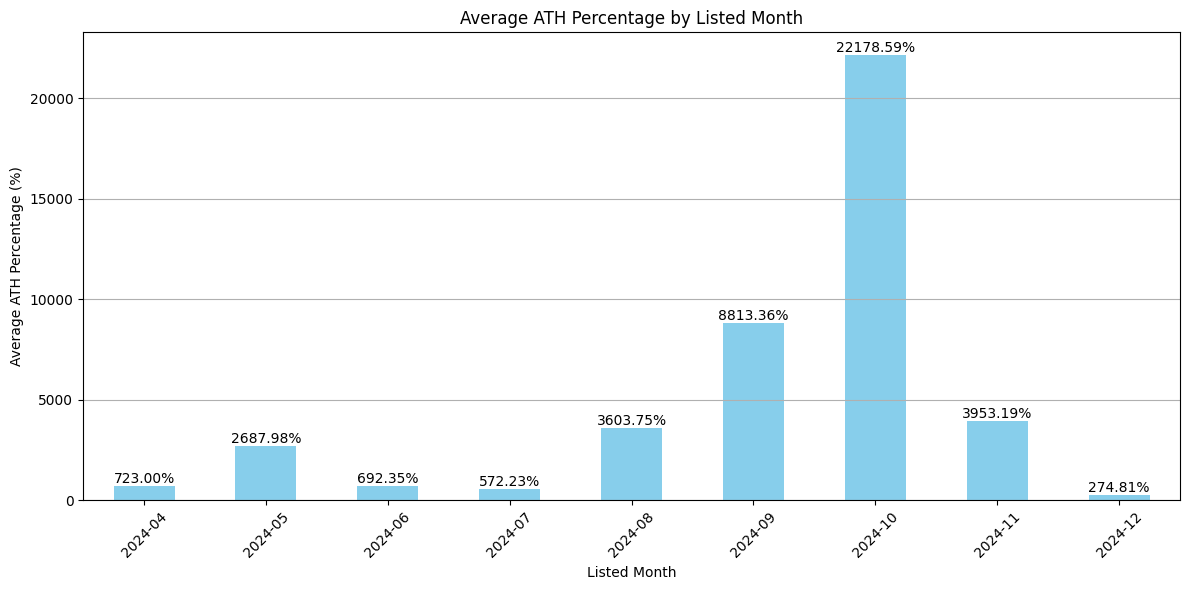

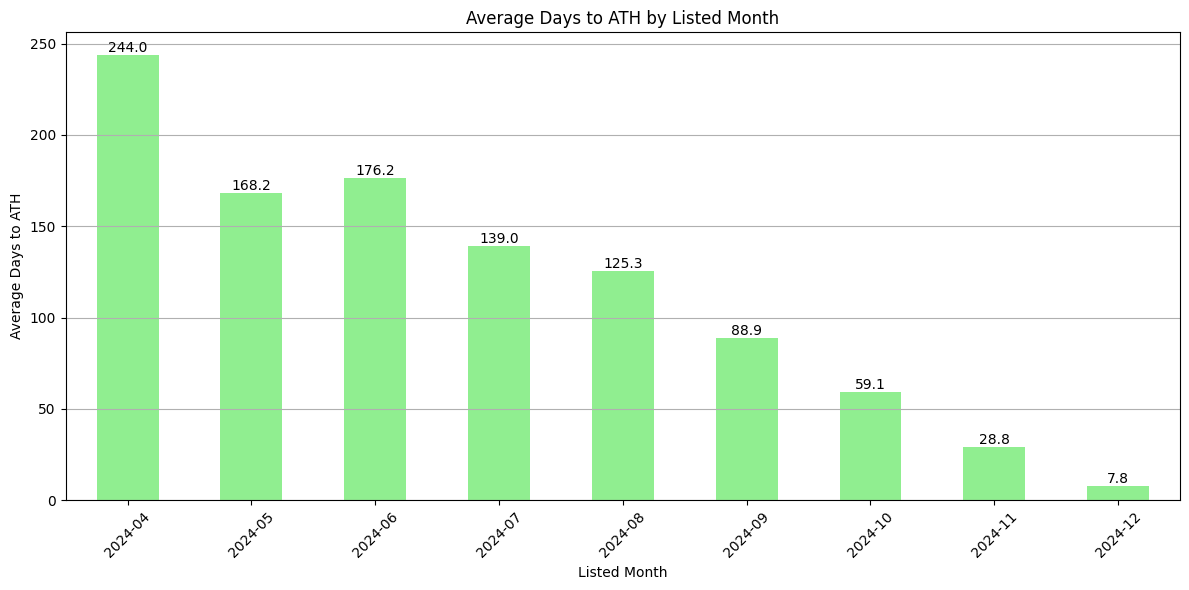

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件
file_path = 'hyperliquid_spot_working_table.csv'
df = pd.read_csv(file_path)

# 确保 Listed date 列是日期格式
df['Listed date'] = pd.to_datetime(df['Listed date'])

# 添加一列表示上市月份
df['Listed Month'] = df['Listed date'].dt.to_period('M')

# 计算 ATH % 和天数
ath_data = df.groupby('Listed Month').agg(
    ATH_Percentage=('ATH %', 'mean'),  # 平均 ATH 百分比
    Days_To_ATH=('Day to ATH', 'mean')  # 平均距离 ATH 的天数
)

# 绘制 ATH 百分比图形
plt.figure(figsize=(12, 6))
ath_data['ATH_Percentage'].plot(kind='bar', color='skyblue')
plt.title('Average ATH Percentage by Listed Month')
plt.xlabel('Listed Month')
plt.ylabel('Average ATH Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# 添加标记，带有 % 符号
for idx in range(len(ath_data)):
    plt.text(idx, ath_data['ATH_Percentage'].iloc[idx], f"{ath_data['ATH_Percentage'].iloc[idx]:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 绘制距离 ATH 天数图形
plt.figure(figsize=(12, 6))
ath_data['Days_To_ATH'].plot(kind='bar', color='lightgreen')
plt.title('Average Days to ATH by Listed Month')
plt.xlabel('Listed Month')
plt.ylabel('Average Days to ATH')
plt.xticks(rotation=45)
plt.grid(axis='y')

# 添加标记
for idx in range(len(ath_data)):
    plt.text(idx, ath_data['Days_To_ATH'].iloc[idx], f"{ath_data['Days_To_ATH'].iloc[idx]:.1f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件
file_path = 'hyperliquid_spot_working_table.csv'
df = pd.read_csv(file_path)

# 确保 Listed date 列是日期格式
df['Listed date'] = pd.to_datetime(df['Listed date'])

# 添加一列表示上市月份
df['Listed Month'] = df['Listed date'].dt.to_period('M')

# 计算平均 ATH 日期
# 假设 'ATH date' 列是字符串格式，需要转换为 datetime
df['ATH date'] = pd.to_datetime(df['ATH date'])

# 计算每个月的平均 ATH 日期
avg_ath_dates = df.groupby('Listed Month')['ATH date'].mean()

# 打印每个月的平均 ATH 日期
avg_ath_dates


Listed Month
2024-04   2024-12-16 00:00:00.000000000
2024-05   2024-11-08 10:40:00.000000000
2024-06   2024-12-08 22:44:12.631578880
2024-07   2024-11-28 19:45:52.941176576
2024-08   2024-12-16 21:00:00.000000000
2024-09   2024-12-16 21:20:00.000000000
2024-10   2024-12-16 20:34:17.142857216
2024-11   2024-12-15 22:04:48.000000000
2024-12   2024-12-14 18:51:25.714285824
Freq: M, Name: ATH date, dtype: datetime64[ns]